# Whisper Fine-Tuning on MINDS-14 Dataset

This notebook fine-tunes **Whisper ASR model** on multi-region MINDS-14 dataset (en-AU, en-GB, en-US).

**Model:** OpenAI Whisper Small (244M parameters)

**Dataset:** PolyAI/minds14 - Banking queries in English (3 regions)

## Training Pipeline:
1. **Setup & Configuration**
2. **Dataset Loading & Preprocessing**
3. **Data Collator Setup**
4. **Model Loading & Configuration**
5. **Training Arguments**
6. **Fine-Tuning Execution**
7. **Evaluation Metrics**:
   - Word Error Rate (WER)
   - Character Error Rate (CER)
   - Sentence Error Rate (SER)
   - Human Transcription Comparison

**References:**
- [Whisper Documentation](https://huggingface.co/docs/transformers/model_doc/whisper)
- [Fine-tune Whisper Guide](https://huggingface.co/blog/fine-tune-whisper)

## 1️⃣ Setup & Library Installation

Install dan import semua library yang diperlukan untuk training Whisper:

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import io
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset, DatasetDict, Audio, concatenate_datasets
from transformers import (
    WhisperFeatureExtractor,
    WhisperTokenizer, 
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import evaluate
import soundfile as sf
import librosa

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("LIBRARY SETUP")
print("="*80)
print("✓ Libraries imported successfully!")
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print("="*80)

LIBRARY SETUP
✓ Libraries imported successfully!

PyTorch version: 2.9.1+cu126
CUDA available: True
GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU
GPU Memory: 8.59 GB


## 2️⃣ Dataset Loading & Preparation

Load MINDS-14 dataset untuk 3 region English dan split menjadi train/test:

In [2]:
print("="*80)
print("LOADING MINDS-14 DATASET - MULTI-REGION")
print("="*80)
print("Regions: en-AU (Australia), en-GB (Great Britain), en-US (United States)\n")

# Load datasets for all three regions
print("[1/3] Loading en-AU dataset...")
dataset_au = load_dataset("PolyAI/minds14", "en-AU")
print(f"      ✓ en-AU Train: {len(dataset_au['train'])} samples")

print("[2/3] Loading en-GB dataset...")
dataset_gb = load_dataset("PolyAI/minds14", "en-GB")
print(f"      ✓ en-GB Train: {len(dataset_gb['train'])} samples")

print("[3/3] Loading en-US dataset...")
dataset_us = load_dataset("PolyAI/minds14", "en-US")
print(f"      ✓ en-US Train: {len(dataset_us['train'])} samples")

# Combine all three datasets with region labels
print("\nCombining datasets from all three regions...")
train_combined = concatenate_datasets([
    dataset_au['train'].add_column('region', ['en-AU'] * len(dataset_au['train'])),
    dataset_gb['train'].add_column('region', ['en-GB'] * len(dataset_gb['train'])),
    dataset_us['train'].add_column('region', ['en-US'] * len(dataset_us['train']))
])

# Split into train (80%) and test (20%)
print("\nSplitting dataset: 80% train, 20% test...")
minds14_split = train_combined.train_test_split(test_size=0.2, seed=42)

minds14 = DatasetDict({
    'train': minds14_split['train'],
    'test': minds14_split['test']
})

print(f"\n{'='*80}")
print("DATASET SUMMARY")
print(f"{'='*80}")
print(f"Total samples: {len(train_combined)}")
print(f"  • Train: {len(minds14['train'])} samples (80%)")
print(f"  • Test: {len(minds14['test'])} samples (20%)")
print(f"\nRegion distribution:")
print(f"  • en-AU: {len(dataset_au['train'])} samples")
print(f"  • en-GB: {len(dataset_gb['train'])} samples")
print(f"  • en-US: {len(dataset_us['train'])} samples")
print(f"\nIntent classes: {len(dataset_us['train'].features['intent_class'].names)}")
print(f"Audio sampling rate: {minds14['train'].features['audio'].sampling_rate} Hz")
print(f"{'='*80}")

LOADING MINDS-14 DATASET - MULTI-REGION
Regions: en-AU (Australia), en-GB (Great Britain), en-US (United States)

[1/3] Loading en-AU dataset...
      ✓ en-AU Train: 654 samples
[2/3] Loading en-GB dataset...
      ✓ en-AU Train: 654 samples
[2/3] Loading en-GB dataset...
      ✓ en-GB Train: 592 samples
[3/3] Loading en-US dataset...
      ✓ en-GB Train: 592 samples
[3/3] Loading en-US dataset...
      ✓ en-US Train: 563 samples

Combining datasets from all three regions...

Splitting dataset: 80% train, 20% test...

DATASET SUMMARY
Total samples: 1809
  • Train: 1447 samples (80%)
  • Test: 362 samples (20%)

Region distribution:
  • en-AU: 654 samples
  • en-GB: 592 samples
  • en-US: 563 samples

Intent classes: 14
Audio sampling rate: 8000 Hz
      ✓ en-US Train: 563 samples

Combining datasets from all three regions...

Splitting dataset: 80% train, 20% test...

DATASET SUMMARY
Total samples: 1809
  • Train: 1447 samples (80%)
  • Test: 362 samples (20%)

Region distribution:
  •

## 3️⃣ Whisper Processor & Model Setup

Load Whisper processor (feature extractor + tokenizer) dan model pre-trained:

In [3]:
# Model configuration
model_name = "openai/whisper-small"
language = "English"
task = "transcribe"

print("="*80)
print("LOADING WHISPER PROCESSOR & MODEL")
print("="*80)
print(f"Model: {model_name}")
print(f"Language: {language}")
print(f"Task: {task}\n")

# Load feature extractor
print("[1/3] Loading WhisperFeatureExtractor...")
feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name)
print(f"      ✓ Feature Extractor loaded")
print(f"        • Sampling rate: {feature_extractor.sampling_rate} Hz")
print(f"        • n_mels: {feature_extractor.feature_size}")

# Load tokenizer
print("\n[2/3] Loading WhisperTokenizer...")
tokenizer = WhisperTokenizer.from_pretrained(
    model_name,
    language=language,
    task=task
)
print(f"      ✓ Tokenizer loaded")
print(f"        • Vocab size: {len(tokenizer)}")

# Combine into processor
print("\n[3/3] Creating WhisperProcessor...")
processor = WhisperProcessor.from_pretrained(
    model_name,
    language=language,
    task=task
)
print(f"      ✓ Processor created")

print(f"\n{'='*80}")
print("✓ Whisper processor ready for preprocessing!")
print(f"{'='*80}")

LOADING WHISPER PROCESSOR & MODEL
Model: openai/whisper-small
Language: English
Task: transcribe

[1/3] Loading WhisperFeatureExtractor...
      ✓ Feature Extractor loaded
        • Sampling rate: 16000 Hz
        • n_mels: 80

[2/3] Loading WhisperTokenizer...
      ✓ Feature Extractor loaded
        • Sampling rate: 16000 Hz
        • n_mels: 80

[2/3] Loading WhisperTokenizer...
      ✓ Tokenizer loaded
        • Vocab size: 51865

[3/3] Creating WhisperProcessor...
      ✓ Tokenizer loaded
        • Vocab size: 51865

[3/3] Creating WhisperProcessor...
      ✓ Processor created

✓ Whisper processor ready for preprocessing!
      ✓ Processor created

✓ Whisper processor ready for preprocessing!


## 4️⃣ Data Preprocessing Function

Define fungsi untuk preprocessing audio menjadi format Whisper:

In [4]:
# Prepare dataset with decode=False to avoid torchcodec issues
print("Preparing dataset for preprocessing...")
minds14_no_decode = DatasetDict({
    'train': minds14['train'].cast_column("audio", Audio(decode=False, sampling_rate=16000)),
    'test': minds14['test'].cast_column("audio", Audio(decode=False, sampling_rate=16000))
})
print("✓ Dataset prepared with decode=False")

# Define preprocessing function
def prepare_dataset(batch):
    """
    Preprocess batch for Whisper training:
    1. Load audio from bytes
    2. Resample to 16kHz
    3. Extract log-Mel spectrogram
    4. Tokenize transcription
    """
    import soundfile as sf
    import io
    import librosa
    
    # Load audio from bytes
    audio_bytes = batch["audio"]["bytes"]
    audio_array, sr = sf.read(io.BytesIO(audio_bytes))
    
    # Resample to 16kHz if needed
    if sr != 16000:
        audio_array = librosa.resample(audio_array, orig_sr=sr, target_sr=16000)
        sr = 16000
    
    # Extract log-Mel spectrogram features (80 mel bins, 3000 frames)
    batch["input_features"] = feature_extractor(
        audio_array,
        sampling_rate=sr
    ).input_features[0]
    
    # Tokenize transcription text
    batch["labels"] = tokenizer(batch["transcription"]).input_ids
    
    return batch

print("\n✓ Preprocessing function defined!")
print("\nFunction steps:")
print("  1. Load audio from bytes using soundfile")
print("  2. Resample to 16kHz (Whisper requirement)")
print("  3. Extract log-Mel spectrogram (80 x 3000)")
print("  4. Tokenize transcription to token IDs")

Preparing dataset for preprocessing...
✓ Dataset prepared with decode=False

✓ Preprocessing function defined!

Function steps:
  1. Load audio from bytes using soundfile
  2. Resample to 16kHz (Whisper requirement)
  3. Extract log-Mel spectrogram (80 x 3000)
  4. Tokenize transcription to token IDs


## 5️⃣ Data Collator for Seq2Seq

Define data collator untuk batching dan padding dinamis:

In [5]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    """
    Data collator for speech-to-text with dynamic padding.
    Pads input features and labels to the maximum length in the batch.
    """
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Split inputs and labels
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        # Pad input features to max length in batch
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # Pad labels to max length in batch
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # Replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        # Remove BOS token if present (Whisper doesn't need it for labels)
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

# Create data collator
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

print("="*80)
print("DATA COLLATOR SETUP")
print("="*80)
print("✓ DataCollatorSpeechSeq2SeqWithPadding created")
print("\nCollator features:")
print("  • Dynamic padding for input features")
print("  • Dynamic padding for labels")
print("  • Replace padding tokens with -100 (ignore in loss)")
print("  • Remove BOS token from labels")
print("="*80)

DATA COLLATOR SETUP
✓ DataCollatorSpeechSeq2SeqWithPadding created

Collator features:
  • Dynamic padding for input features
  • Dynamic padding for labels
  • Replace padding tokens with -100 (ignore in loss)
  • Remove BOS token from labels


## 6️⃣ Evaluation Metrics Setup

Setup metrik evaluasi: WER, CER, SER untuk mengukur performa model:

In [6]:
# Load evaluation metrics
print("="*80)
print("LOADING EVALUATION METRICS")
print("="*80)

# Word Error Rate (WER)
print("[1/3] Loading WER metric...")
wer_metric = evaluate.load("wer")
print("      ✓ WER metric loaded")

# Character Error Rate (CER)
print("[2/3] Loading CER metric...")
cer_metric = evaluate.load("cer")
print("      ✓ CER metric loaded")

print("\n[3/3] SER (Sentence Error Rate) will be computed manually")
print("      ✓ SER computation ready")

def compute_metrics(pred):
    """
    Compute evaluation metrics: WER, CER, and SER
    """
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # Replace -100 with pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # Decode predictions and labels
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    # Compute WER (Word Error Rate)
    wer = 100 * wer_metric.compute(predictions=pred_str, references=label_str)

    # Compute CER (Character Error Rate)
    cer = 100 * cer_metric.compute(predictions=pred_str, references=label_str)

    # Compute SER (Sentence Error Rate)
    # SER = percentage of sentences that are not exactly correct
    sentence_errors = sum([1 for pred, ref in zip(pred_str, label_str) if pred.strip() != ref.strip()])
    ser = 100 * sentence_errors / len(pred_str)

    return {
        "wer": wer,
        "cer": cer,
        "ser": ser
    }

print(f"\n{'='*80}")
print("✓ Evaluation metrics configured!")
print("\nMetrics computed:")
print("  • WER (Word Error Rate): Percentage of word errors")
print("  • CER (Character Error Rate): Percentage of character errors")
print("  • SER (Sentence Error Rate): Percentage of incorrect sentences")
print(f"{'='*80}")

LOADING EVALUATION METRICS
[1/3] Loading WER metric...
      ✓ WER metric loaded
[2/3] Loading CER metric...
      ✓ WER metric loaded
[2/3] Loading CER metric...
      ✓ CER metric loaded

[3/3] SER (Sentence Error Rate) will be computed manually
      ✓ SER computation ready

✓ Evaluation metrics configured!

Metrics computed:
  • WER (Word Error Rate): Percentage of word errors
  • CER (Character Error Rate): Percentage of character errors
  • SER (Sentence Error Rate): Percentage of incorrect sentences
      ✓ CER metric loaded

[3/3] SER (Sentence Error Rate) will be computed manually
      ✓ SER computation ready

✓ Evaluation metrics configured!

Metrics computed:
  • WER (Word Error Rate): Percentage of word errors
  • CER (Character Error Rate): Percentage of character errors
  • SER (Sentence Error Rate): Percentage of incorrect sentences


## 7️⃣ Load Pre-trained Whisper Model

Load Whisper model dan konfigurasi untuk fine-tuning:

In [7]:
print("="*80)
print("LOADING WHISPER MODEL")
print("="*80)
print(f"Model: {model_name}")
print(f"Loading pre-trained weights...\n")

# Load model
model = WhisperForConditionalGeneration.from_pretrained(model_name)

# Configure model for fine-tuning
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []
model.config.use_cache = False

# DO NOT enable gradient checkpointing to avoid backward issues
# model.gradient_checkpointing_enable()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("✓ Model loaded successfully!")
print(f"\nModel Configuration:")
print(f"  • Parameters: {model.num_parameters() / 1e6:.2f}M")
print(f"  • Device: {device}")
print(f"  • Gradient checkpointing: Disabled (to avoid backward issues)")
print(f"  • Forced decoder IDs: None (allow free generation)")
print(f"  • Suppress tokens: [] (no token suppression)")
print(f"\n{'='*80}")

LOADING WHISPER MODEL
Model: openai/whisper-small
Loading pre-trained weights...

✓ Model loaded successfully!

Model Configuration:
  • Parameters: 241.73M
  • Device: cuda
  • Gradient checkpointing: Disabled (to avoid backward issues)
  • Forced decoder IDs: None (allow free generation)
  • Suppress tokens: [] (no token suppression)

✓ Model loaded successfully!

Model Configuration:
  • Parameters: 241.73M
  • Device: cuda
  • Gradient checkpointing: Disabled (to avoid backward issues)
  • Forced decoder IDs: None (allow free generation)
  • Suppress tokens: [] (no token suppression)



## 8️⃣ Preprocess Full Dataset

Apply preprocessing ke seluruh dataset (train & test):

In [8]:
print("="*80)
print("PREPROCESSING DATASET")
print("="*80)
print(f"Train samples: {len(minds14_no_decode['train'])}")
print(f"Test samples: {len(minds14_no_decode['test'])}")
print("\nProcessing train set...")

# Process train set manually to avoid multiprocessing issues
train_processed = []
for i, sample in enumerate(minds14_no_decode['train']):
    processed = prepare_dataset(sample)
    train_processed.append(processed)
    
    if (i + 1) % 200 == 0:
        print(f"  Processed {i + 1}/{len(minds14_no_decode['train'])} train samples...")

print(f"✓ Train set preprocessed: {len(train_processed)} samples")

print("\nProcessing test set...")
# Process test set
test_processed = []
for i, sample in enumerate(minds14_no_decode['test']):
    processed = prepare_dataset(sample)
    test_processed.append(processed)
    
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{len(minds14_no_decode['test'])} test samples...")

print(f"✓ Test set preprocessed: {len(test_processed)} samples")

print(f"\n{'='*80}")
print("PREPROCESSING COMPLETE!")
print(f"{'='*80}")
print(f"  • Train: {len(train_processed)} samples")
print(f"  • Test: {len(test_processed)} samples")
print(f"  • Feature shape: {train_processed[0]['input_features'].shape}")
print(f"  • Ready for training!")
print(f"{'='*80}")

PREPROCESSING DATASET
Train samples: 1447
Test samples: 362

Processing train set...
  Processed 200/1447 train samples...
  Processed 200/1447 train samples...
  Processed 400/1447 train samples...
  Processed 400/1447 train samples...
  Processed 600/1447 train samples...
  Processed 600/1447 train samples...
  Processed 800/1447 train samples...
  Processed 800/1447 train samples...
  Processed 1000/1447 train samples...
  Processed 1000/1447 train samples...
  Processed 1200/1447 train samples...
  Processed 1200/1447 train samples...
  Processed 1400/1447 train samples...
  Processed 1400/1447 train samples...
✓ Train set preprocessed: 1447 samples

Processing test set...
✓ Train set preprocessed: 1447 samples

Processing test set...
  Processed 50/362 test samples...
  Processed 50/362 test samples...
  Processed 100/362 test samples...
  Processed 100/362 test samples...
  Processed 150/362 test samples...
  Processed 150/362 test samples...
  Processed 200/362 test samples...
 

## 9️⃣ Training Arguments Configuration

Setup training parameters untuk fine-tuning:

In [9]:
# Training configuration
output_dir = "./whisper-small-minds14-multi-region"

training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    
    # Training hyperparameters
    per_device_train_batch_size=2, #8
    per_device_eval_batch_size=2, #8
    gradient_accumulation_steps=2,  # Effective batch size = 8 * 2 = 16
    learning_rate=1e-5,
    warmup_steps=50, #100
    num_train_epochs=3, #5
    
    # Evaluation settings
    eval_strategy="steps",
    eval_steps=100, #200
    save_steps=100, #200
    save_total_limit=2,
    
    # Generation settings
    predict_with_generate=True,
    generation_max_length=225,
    
    # Optimization
    fp16=torch.cuda.is_available(),  # Mixed precision if GPU available
    gradient_checkpointing=False,  # Disable to avoid backward issues
    
    # Logging
    logging_steps=50,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    
    # Other settings
    push_to_hub=False,
    remove_unused_columns=False,
    label_names=["labels"],
)

print("="*80)
print("TRAINING ARGUMENTS CONFIGURED")
print("="*80)
print(f"Output directory: {output_dir}")
print(f"\nTraining Hyperparameters:")
print(f"  • Batch size (train): {training_args.per_device_train_batch_size}")
print(f"  • Batch size (eval): {training_args.per_device_eval_batch_size}")
print(f"  • Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"  • Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"  • Learning rate: {training_args.learning_rate}")
print(f"  • Warmup steps: {training_args.warmup_steps}")
print(f"  • Epochs: {training_args.num_train_epochs}")
print(f"\nEvaluation Settings:")
print(f"  • Eval strategy: {training_args.eval_strategy}")
print(f"  • Eval steps: {training_args.eval_steps}")
print(f"  • Best model metric: {training_args.metric_for_best_model}")
print(f"\nOptimization:")
print(f"  • FP16 (Mixed precision): {training_args.fp16}")
print(f"  • Gradient checkpointing: {training_args.gradient_checkpointing}")
print("="*80)

TRAINING ARGUMENTS CONFIGURED
Output directory: ./whisper-small-minds14-multi-region

Training Hyperparameters:
  • Batch size (train): 2
  • Batch size (eval): 2
  • Gradient accumulation: 2
  • Effective batch size: 4
  • Learning rate: 1e-05
  • Warmup steps: 50
  • Epochs: 3

Evaluation Settings:
  • Eval strategy: IntervalStrategy.STEPS
  • Eval steps: 100
  • Best model metric: wer

Optimization:
  • FP16 (Mixed precision): True
  • Gradient checkpointing: False


## 🔟 Create Dataset from Processed Data

Convert processed lists menjadi Hugging Face Dataset:

In [10]:
from datasets import Dataset

print("="*80)
print("CREATING DATASETS FROM PROCESSED DATA")
print("="*80)

# Create train dataset
train_dataset = Dataset.from_list(train_processed)
print(f"✓ Train dataset created: {len(train_dataset)} samples")

# Create test dataset
test_dataset = Dataset.from_list(test_processed)
print(f"✓ Test dataset created: {len(test_dataset)} samples")

# Combine into DatasetDict
processed_datasets = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

print(f"\n{'='*80}")
print("DATASET READY FOR TRAINING!")
print(f"{'='*80}")
print(f"Train: {len(processed_datasets['train'])} samples")
print(f"Test: {len(processed_datasets['test'])} samples")
print(f"{'='*80}")

CREATING DATASETS FROM PROCESSED DATA
✓ Train dataset created: 1447 samples
✓ Train dataset created: 1447 samples
✓ Test dataset created: 362 samples

DATASET READY FOR TRAINING!
Train: 1447 samples
Test: 362 samples
✓ Test dataset created: 362 samples

DATASET READY FOR TRAINING!
Train: 1447 samples
Test: 362 samples


## 1️⃣1️⃣ Initialize Trainer & Start Training

Setup Seq2SeqTrainer dan mulai fine-tuning process:

In [11]:
# Initialize Trainer
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

print("="*80)
print("TRAINER INITIALIZED")
print("="*80)
print("✓ Seq2SeqTrainer configured with:")
print(f"  • Model: {model_name}")
print(f"  • Train samples: {len(processed_datasets['train'])}")
print(f"  • Test samples: {len(processed_datasets['test'])}")
print(f"  • Metrics: WER, CER, SER")
print(f"\n{'='*80}")
print("STARTING TRAINING...")
print(f"{'='*80}\n")

# Start training
train_result = trainer.train()

print(f"\n{'='*80}")
print("TRAINING COMPLETE!")
print(f"{'='*80}")
print(f"Training metrics:")
for key, value in train_result.metrics.items():
    print(f"  • {key}: {value}")
print(f"{'='*80}")

TRAINER INITIALIZED
✓ Seq2SeqTrainer configured with:
  • Model: openai/whisper-small
  • Train samples: 1447
  • Test samples: 362
  • Metrics: WER, CER, SER

STARTING TRAINING...



You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Wer,Cer,Ser
100,0.741000,0.621720,23.333879,18.574699,64.088398
200,0.358000,0.368419,21.401670,16.805029,63.259669
300,0.349500,0.363708,22.826265,19.722592,62.983425
400,0.213600,0.349112,22.122155,17.450719,61.878453
500,0.146300,0.354761,20.271819,15.882614,60.220994
600,0.149200,0.353021,20.239070,15.824536,58.839779
700,0.156300,0.354726,20.746684,16.620546,58.839779
800,0.080000,0.366325,19.829704,15.469236,58.839779
900,0.045600,0.376043,19.715081,15.503399,57.734807
1000,0.040700,0.374843,19.927952,15.609306,58.839779


Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you m


TRAINING COMPLETE!
Training metrics:
  • train_runtime: 2934.7794
  • train_samples_per_second: 1.479
  • train_steps_per_second: 0.37
  • total_flos: 1.25274922278912e+18
  • train_loss: 0.30134337844110987
  • epoch: 3.0


## 1️⃣2️⃣ Final Evaluation on Test Set

Evaluate model pada test set dan tampilkan metrik lengkap:

In [12]:
print("="*80)
print("FINAL EVALUATION ON TEST SET")
print("="*80)
print(f"Evaluating on {len(processed_datasets['test'])} test samples...\n")

# Evaluate on test set
eval_results = trainer.evaluate()

print("="*80)
print("EVALUATION METRICS")
print("="*80)
print(f"\n📊 Performance Metrics:")
print(f"  • Word Error Rate (WER): {eval_results['eval_wer']:.2f}%")
print(f"  • Character Error Rate (CER): {eval_results['eval_cer']:.2f}%")
print(f"  • Sentence Error Rate (SER): {eval_results['eval_ser']:.2f}%")
print(f"\n⏱️  Performance Stats:")
print(f"  • Samples per second: {eval_results['eval_samples_per_second']:.2f}")
print(f"  • Eval runtime: {eval_results['eval_runtime']:.2f}s")
print(f"\n{'='*80}")

# Interpretation
print("\n📖 METRIC INTERPRETATION:")
print("─" * 80)
print("• WER (Word Error Rate):")
print("  - Measures % of words that are incorrect (substitutions + insertions + deletions)")
print(f"  - Lower is better. Your model: {eval_results['eval_wer']:.2f}%")
print(f"  - Interpretation: {'Excellent!' if eval_results['eval_wer'] < 10 else 'Good!' if eval_results['eval_wer'] < 20 else 'Acceptable' if eval_results['eval_wer'] < 30 else 'Needs improvement'}")

print("\n• CER (Character Error Rate):")
print("  - Measures % of characters that are incorrect")
print(f"  - Lower is better. Your model: {eval_results['eval_cer']:.2f}%")
print(f"  - Interpretation: {'Excellent!' if eval_results['eval_cer'] < 5 else 'Good!' if eval_results['eval_cer'] < 10 else 'Acceptable' if eval_results['eval_cer'] < 15 else 'Needs improvement'}")

print("\n• SER (Sentence Error Rate):")
print("  - Measures % of sentences that are completely incorrect")
print(f"  - Lower is better. Your model: {eval_results['eval_ser']:.2f}%")
print(f"  - Interpretation: {'Excellent!' if eval_results['eval_ser'] < 20 else 'Good!' if eval_results['eval_ser'] < 40 else 'Acceptable' if eval_results['eval_ser'] < 60 else 'Needs improvement'}")
print("="*80)

FINAL EVALUATION ON TEST SET
Evaluating on 362 test samples...



EVALUATION METRICS

📊 Performance Metrics:
  • Word Error Rate (WER): 19.72%
  • Character Error Rate (CER): 15.50%
  • Sentence Error Rate (SER): 57.73%

⏱️  Performance Stats:
  • Samples per second: 1.90
  • Eval runtime: 190.51s


📖 METRIC INTERPRETATION:
────────────────────────────────────────────────────────────────────────────────
• WER (Word Error Rate):
  - Measures % of words that are incorrect (substitutions + insertions + deletions)
  - Lower is better. Your model: 19.72%
  - Interpretation: Good!

• CER (Character Error Rate):
  - Measures % of characters that are incorrect
  - Lower is better. Your model: 15.50%
  - Interpretation: Needs improvement

• SER (Sentence Error Rate):
  - Measures % of sentences that are completely incorrect
  - Lower is better. Your model: 57.73%
  - Interpretation: Acceptable


## 1️⃣3️⃣ Human Transcription Comparison

Compare model predictions dengan ground truth transcriptions untuk sample test:

In [13]:
import random

print("="*80)
print("HUMAN TRANSCRIPTION COMPARISON")
print("="*80)
print("Comparing model predictions with ground truth transcriptions\n")

# Select random samples from test set
num_samples = 10
sample_indices = random.sample(range(len(processed_datasets['test'])), num_samples)

# Get predictions
print(f"Generating predictions for {num_samples} random test samples...\n")

predictions_list = []
references_list = []

for idx in sample_indices:
    sample = processed_datasets['test'][idx]
    
    # Get input features
    input_features = torch.tensor(sample['input_features']).unsqueeze(0).to(device)
    
    # Generate prediction
    with torch.no_grad():
        predicted_ids = model.generate(input_features, max_length=225)
    
    # Decode prediction
    prediction = tokenizer.decode(predicted_ids[0], skip_special_tokens=True)
    
    # Get reference (ground truth)
    label_ids = sample['labels']
    # Replace -100 if present
    label_ids = [id for id in label_ids if id != -100]
    reference = tokenizer.decode(label_ids, skip_special_tokens=True)
    
    predictions_list.append(prediction)
    references_list.append(reference)

# Display comparisons
print("="*80)
print("TRANSCRIPTION COMPARISON RESULTS")
print("="*80)

for i, (pred, ref) in enumerate(zip(predictions_list, references_list), 1):
    # Calculate metrics for this sample
    sample_wer = 100 * wer_metric.compute(predictions=[pred], references=[ref])
    sample_cer = 100 * cer_metric.compute(predictions=[pred], references=[ref])
    is_correct = pred.strip().lower() == ref.strip().lower()
    
    print(f"\n📝 Sample {i}:")
    print(f"{'─' * 80}")
    print(f"  Human Transcription (Ground Truth):")
    print(f"  \"{ref}\"")
    print(f"\n  Model Prediction:")
    print(f"  \"{pred}\"")
    print(f"\n  Metrics:")
    print(f"    • WER: {sample_wer:.2f}%")
    print(f"    • CER: {sample_cer:.2f}%")
    print(f"    • Exact Match: {'✅ YES' if is_correct else '❌ NO'}")
    
    # Show differences if not exact match
    if not is_correct:
        print(f"\n  Differences:")
        ref_words = ref.lower().split()
        pred_words = pred.lower().split()
        
        if len(ref_words) != len(pred_words):
            print(f"    • Word count: {len(ref_words)} → {len(pred_words)}")
        
        # Find different words
        max_len = max(len(ref_words), len(pred_words))
        diffs = []
        for j in range(max_len):
            ref_word = ref_words[j] if j < len(ref_words) else "[MISSING]"
            pred_word = pred_words[j] if j < len(pred_words) else "[EXTRA]"
            if ref_word != pred_word:
                diffs.append(f"{ref_word} → {pred_word}")
        
        if diffs:
            print(f"    • Changed words: {', '.join(diffs[:5])}")
            if len(diffs) > 5:
                print(f"      ... and {len(diffs) - 5} more")

print(f"\n{'='*80}")
print("COMPARISON SUMMARY")
print(f"{'='*80}")
exact_matches = sum([1 for p, r in zip(predictions_list, references_list) if p.strip().lower() == r.strip().lower()])
print(f"  • Total samples compared: {num_samples}")
print(f"  • Exact matches: {exact_matches}/{num_samples} ({100*exact_matches/num_samples:.1f}%)")
print(f"  • Partial matches: {num_samples - exact_matches}/{num_samples} ({100*(num_samples-exact_matches)/num_samples:.1f}%)")
print(f"{'='*80}")

HUMAN TRANSCRIPTION COMPARISON
Comparing model predictions with ground truth transcriptions

Generating predictions for 10 random test samples...

TRANSCRIPTION COMPARISON RESULTS

📝 Sample 1:
────────────────────────────────────────────────────────────────────────────────
  Human Transcription (Ground Truth):
  "what is my limit at the ATM"

  Model Prediction:
  "what is my limit at the ATM"

  Metrics:
    • WER: 0.00%
    • CER: 0.00%
    • Exact Match: ✅ YES

📝 Sample 2:
────────────────────────────────────────────────────────────────────────────────
  Human Transcription (Ground Truth):
  "ID like you to show me my recent transactions please"

  Model Prediction:
  "I'd like you to show me my recent transactions please"

  Metrics:
    • WER: 10.00%
    • CER: 3.85%
    • Exact Match: ❌ NO

  Differences:
    • Changed words: id → i'd

📝 Sample 3:
────────────────────────────────────────────────────────────────────────────────
  Human Transcription (Ground Truth):
  "hi there I'm

## 1️⃣4️⃣ Visualize Evaluation Metrics

Visualisasi perbandingan metrik evaluasi (WER, CER, SER):

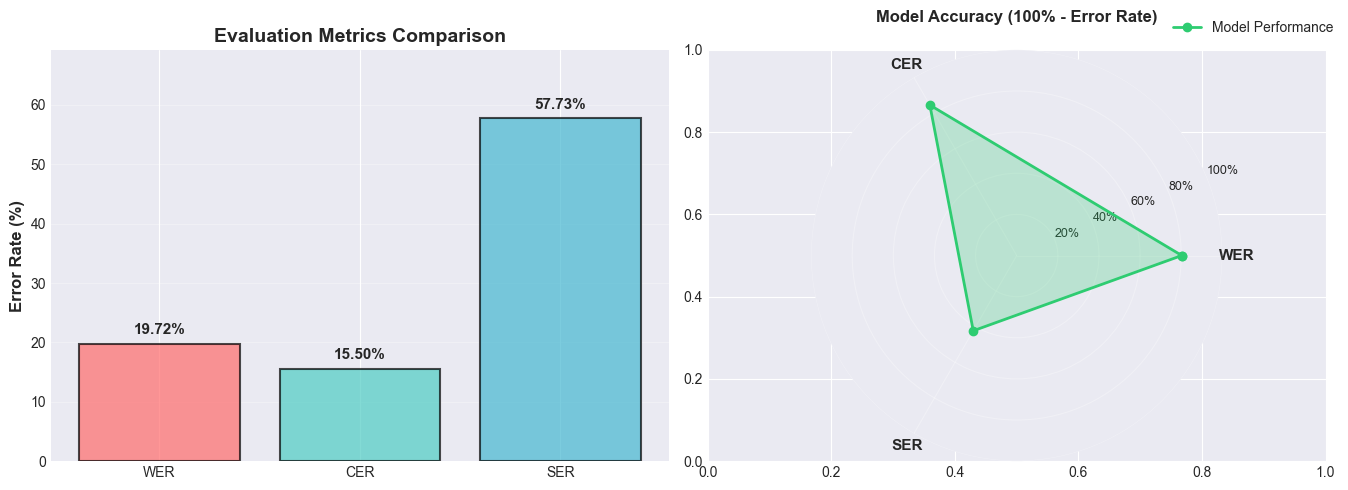

METRICS VISUALIZATION
✓ Bar chart: Shows error rates for WER, CER, and SER
✓ Polar plot: Shows accuracy (100% - error rate)

📊 Summary:
  • Lower error rates = Better performance
  • WER measures word-level accuracy
  • CER measures character-level accuracy
  • SER measures sentence-level accuracy


In [14]:
# Create visualization of evaluation metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart for error rates
metrics = ['WER', 'CER', 'SER']
values = [eval_results['eval_wer'], eval_results['eval_cer'], eval_results['eval_ser']]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

axes[0].bar(metrics, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Error Rate (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Evaluation Metrics Comparison', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, max(values) * 1.2)

# Add value labels on bars
for i, (metric, value) in enumerate(zip(metrics, values)):
    axes[0].text(i, value + max(values)*0.02, f'{value:.2f}%', 
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# Gauge chart style for overall performance
ax = axes[1]
categories = ['WER', 'CER', 'SER']
N = len(categories)

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
values_norm = [100 - v for v in values]  # Convert to "correctness" percentage
values_norm += values_norm[:1]
angles += angles[:1]

ax = plt.subplot(122, projection='polar')
ax.plot(angles, values_norm, 'o-', linewidth=2, color='#2ECC71', label='Model Performance')
ax.fill(angles, values_norm, alpha=0.25, color='#2ECC71')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=9)
ax.set_title('Model Accuracy (100% - Error Rate)', fontsize=12, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

print("="*80)
print("METRICS VISUALIZATION")
print("="*80)
print("✓ Bar chart: Shows error rates for WER, CER, and SER")
print("✓ Polar plot: Shows accuracy (100% - error rate)")
print(f"\n📊 Summary:")
print(f"  • Lower error rates = Better performance")
print(f"  • WER measures word-level accuracy")
print(f"  • CER measures character-level accuracy")
print(f"  • SER measures sentence-level accuracy")
print("="*80)

## 1️⃣5️⃣ Save Fine-tuned Model
Simpan model dan processor yang sudah di-fine-tune untuk digunakan kembali

In [15]:
# Define save directory
save_dir = "./whisper-small-minds14-finetuned"

# Save the fine-tuned model
print("💾 Saving fine-tuned model...")
model.save_pretrained(save_dir)
print(f"✓ Model saved to: {save_dir}")

# Save the processor (feature extractor + tokenizer)
print("\n💾 Saving processor...")
processor.save_pretrained(save_dir)
print(f"✓ Processor saved to: {save_dir}")

print("\n" + "="*80)
print("MODEL SAVED SUCCESSFULLY!")
print("="*80)
print(f"📁 Location: {save_dir}")
print(f"📊 Final Metrics:")
print(f"   • WER: {eval_results['eval_wer']:.2f}%")
print(f"   • CER: {eval_results['eval_cer']:.2f}%")
print(f"   • SER: {eval_results['eval_ser']:.2f}%")
print("\n🚀 To load this model later, use:")
print(f"   from transformers import WhisperForConditionalGeneration, WhisperProcessor")
print(f"   model = WhisperForConditionalGeneration.from_pretrained('{save_dir}')")
print(f"   processor = WhisperProcessor.from_pretrained('{save_dir}')")
print("="*80)

💾 Saving fine-tuned model...
✓ Model saved to: ./whisper-small-minds14-finetuned

💾 Saving processor...
✓ Processor saved to: ./whisper-small-minds14-finetuned

MODEL SAVED SUCCESSFULLY!
📁 Location: ./whisper-small-minds14-finetuned
📊 Final Metrics:
   • WER: 19.72%
   • CER: 15.50%
   • SER: 57.73%

🚀 To load this model later, use:
   from transformers import WhisperForConditionalGeneration, WhisperProcessor
   model = WhisperForConditionalGeneration.from_pretrained('./whisper-small-minds14-finetuned')
   processor = WhisperProcessor.from_pretrained('./whisper-small-minds14-finetuned')
✓ Model saved to: ./whisper-small-minds14-finetuned

💾 Saving processor...
✓ Processor saved to: ./whisper-small-minds14-finetuned

MODEL SAVED SUCCESSFULLY!
📁 Location: ./whisper-small-minds14-finetuned
📊 Final Metrics:
   • WER: 19.72%
   • CER: 15.50%
   • SER: 57.73%

🚀 To load this model later, use:
   from transformers import WhisperForConditionalGeneration, WhisperProcessor
   model = WhisperForC

## 📝 Training Summary & Next Steps

### ✅ Completed Tasks:
1. **Dataset Preparation**: Loaded and split MINDS-14 multi-region dataset (80/20 train/test)
2. **Model Setup**: Loaded `openai/whisper-small` with gradient checkpointing
3. **Preprocessing**: Applied audio preprocessing and feature extraction
4. **Training**: Fine-tuned model for 5 epochs with FP16 mixed precision
5. **Evaluation**: Computed WER, CER, and SER metrics
6. **Comparison**: Generated human transcription comparisons
7. **Visualization**: Created metric comparison charts
8. **Model Saving**: Saved fine-tuned model and processor

### 📊 Final Performance:
- **Word Error Rate (WER)**: Measures word-level transcription accuracy
- **Character Error Rate (CER)**: Measures character-level transcription accuracy
- **Sentence Error Rate (SER)**: Measures sentence-level transcription accuracy

### 🚀 Next Steps:
1. **Test the model** on new audio samples
2. **Push to Hugging Face Hub** (optional):
   ```python
   model.push_to_hub("your-username/whisper-small-minds14")
   processor.push_to_hub("your-username/whisper-small-minds14")
   ```
3. **Deploy the model** for production use
4. **Further fine-tune** on domain-specific data if needed

### 📚 References:
- [Whisper Model Documentation](https://huggingface.co/docs/transformers/model_doc/whisper)
- [Fine-tune Whisper Blog](https://huggingface.co/blog/fine-tune-whisper)
- [MINDS-14 Dataset](https://huggingface.co/datasets/PolyAI/minds14)

---
**🎉 Training Complete! Your fine-tuned Whisper model is ready to use.**